## LRP

In [5]:
def get_ten_images_per_class(dataset, class_index):
    class_data = [data for data in dataset if data[1] == class_index][:10]
    class_loader = torch.utils.data.DataLoader(class_data, batch_size=10, shuffle=False)
    return next(iter(class_loader))


for class_index in range(10):  # CIFAR-10 has 10 classes
    images, _ = get_ten_images_per_class(trainset, class_index)
    R = lrp_instance.relevance(images)

    # Save the tensor for each class as a .npy file
    np.save(f'lrp_class_{class_index}.npy', R.cpu().numpy())

Finished 'relevance' in 4.1041 secs
Finished 'relevance' in 3.8680 secs
Finished 'relevance' in 4.0262 secs
Finished 'relevance' in 4.4267 secs
Finished 'relevance' in 3.9189 secs
Finished 'relevance' in 4.0201 secs
Finished 'relevance' in 4.2573 secs
Finished 'relevance' in 3.8924 secs
Finished 'relevance' in 3.2405 secs
Finished 'relevance' in 3.5393 secs


In [6]:
# Example of loading a .npy file
lrp_values = np.load('lrp_class_0.npy')

print(lrp_values.shape)
print(lrp_values.dtype)
print(lrp_values)

(10, 3, 224, 224)
float32
[[[[5.28066128e-04 7.04658916e-04 5.25835727e-04 ... 2.82778725e-04
    4.91450017e-04 5.02281298e-04]
   [8.85774964e-04 1.06573885e-03 9.48460540e-04 ... 5.10406564e-04
    9.01681953e-04 7.19159609e-04]
   [4.16386407e-04 4.27537918e-04 1.97297777e-04 ... 1.39161537e-04
    3.73884221e-04 3.65222979e-04]
   ...
   [9.12597752e-05 9.75555595e-05 4.56446542e-05 ... 1.54786452e-04
    3.47980007e-04 3.11535987e-04]
   [1.56045106e-04 1.75380439e-04 1.10951645e-04 ... 3.17772152e-04
    5.60330867e-04 4.82410251e-04]
   [9.85614679e-05 1.14064482e-04 7.97573739e-05 ... 2.14264364e-04
    3.95002804e-04 3.04922403e-04]]

  [[7.39637180e-04 8.52435303e-04 6.61518832e-04 ... 3.57754063e-04
    7.26545637e-04 7.07912433e-04]
   [9.61091369e-04 1.13609224e-03 8.72259552e-04 ... 4.78500093e-04
    9.60328383e-04 9.06864298e-04]
   [6.00262196e-04 4.66325786e-04 1.94392895e-04 ... 1.46637001e-04
    4.91862185e-04 4.70837549e-04]
   ...
   [1.22568876e-04 1.02007565e-

In [18]:
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from PIL import Image

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image for VGG16
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (values for ImageNet)
])

# Function to transform the dataset
def transform_dataset(dataset):
    images = []
    labels = []
    for item in dataset:
        image = item['img']
        
        # Check if the image is not a PIL Image
        if not isinstance(image, Image.Image):
            if isinstance(image, torch.Tensor):
                # If it's a tensor, move it to CPU and convert to numpy
                image = image.cpu().numpy()
            image = Image.fromarray(image)  # Convert numpy array to PIL Image
        
        image = transform(image)  # Apply transformations
        images.append(image)
        labels.append(item['label'])
    
    # Convert lists to tensors
    images = torch.stack(images)
    labels = torch.tensor(labels)
    return TensorDataset(images, labels)

# Transform the training dataset
train_dataset = transform_dataset(train_dataset)
test_dataset = transform_dataset(test_dataset)

# Explore the transformed dataset
print(train_dataset)
print(test_dataset)



In [19]:
# Define batch size
batch_size = 32

# Create the DataLoader for training data
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the DataLoader
for images, labels in trainloader:
    print(images.shape)  # Should be [batch_size, 3, 224, 224]
    print(labels.shape)  # Should be [batch_size]
    break


torch.Size([32, 3, 224, 224])
torch.Size([32])


In [ ]:
# Low and high parameters for zB-rule
batch_size: int = 1
shape: Tuple[int] = (batch_size, 3, 224, 224)

low: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.zeros(*shape))
high: torch.Tensor = lrp.norm.ImageNetNorm.normalize(torch.ones(*shape))

# Init layer filter
target_types: Tuple[type] = (Linear, AvgPool)
filter_by_layer_index_type: LayerFilter = LayerFilter(model=model,
                                                      target_types=target_types)

name_map: List[Tuple[List[str], rules.LrpRule,
                     Dict[str, Union[torch.Tensor, float]]]]

# LRP Composite from Montavon's lrp-tutorial
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': 0.25}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': 0.25}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]

# Init LRP
lrp_instance: LRP = LRP(model)

# Prepare model layers for LRP
lrp_instance.convert_layers(name_map)

# Compute relevance attributions
# R: torch.Tensor = lrp_instance.relevance(X)

# Get a batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Forward pass to trigger hooks and get output (for printing activation values)
output = model(images)

# Compute relevance attributions for CIFAR-10 images
R = lrp_instance.relevance(images)


# Display heatmap
lrp_instance.heatmap(R, width=2, height=2)

In [2]:
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.Linear):
        print(f"Registering hook for layer: {name}")
        layer.register_forward_hook(get_activation(name))


Registering hook for layer: features.0
Registering hook for layer: features.2
Registering hook for layer: features.5
Registering hook for layer: features.7
Registering hook for layer: features.10
Registering hook for layer: features.12
Registering hook for layer: features.14
Registering hook for layer: features.17
Registering hook for layer: features.19
Registering hook for layer: features.21
Registering hook for layer: features.24
Registering hook for layer: features.26
Registering hook for layer: features.28
Registering hook for layer: classifier.0
Registering hook for layer: classifier.3
Registering hook for layer: classifier.6


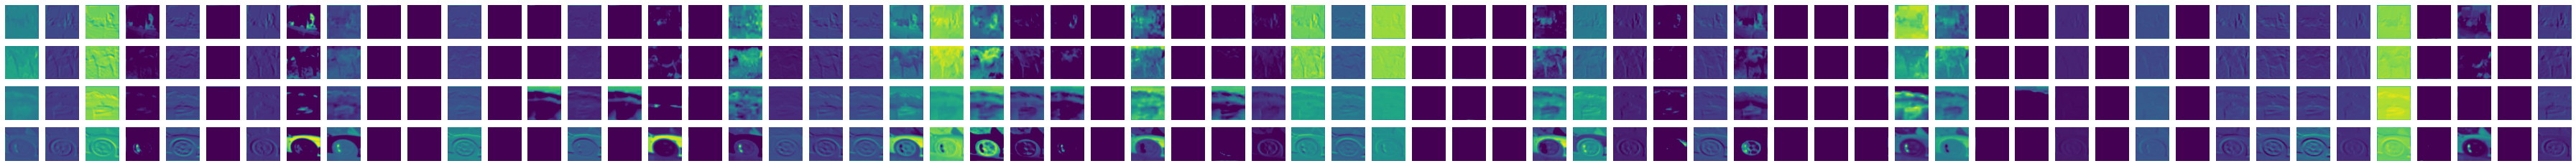

In [3]:
import matplotlib.pyplot as plt

def plot_activations_for_layer(layer_activations):
    # Assuming layer_activations shape is [batch_size, num_filters, height, width]
    batch_size, num_filters, _, _ = layer_activations.shape
    
    fig, axes = plt.subplots(batch_size, num_filters, figsize=(num_filters, batch_size))
    
    for i in range(batch_size):
        for j in range(num_filters):
            ax = axes[i, j]
            ax.imshow(layer_activations[i, j].cpu().numpy(), cmap='viridis')
            ax.axis('off')
    
    plt.show()

# Example: Plot activations for the first conv layer
# Replace 'first_conv_layer_name' with the actual name of the first conv layer in your model
plot_activations_for_layer(activations['features.0'])


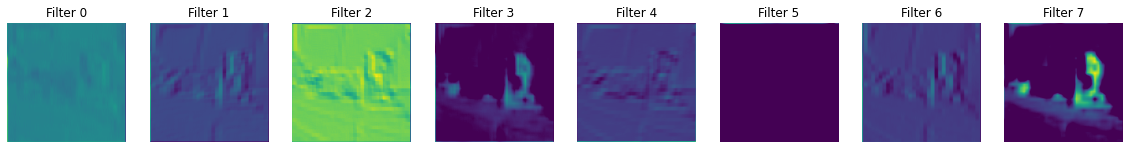

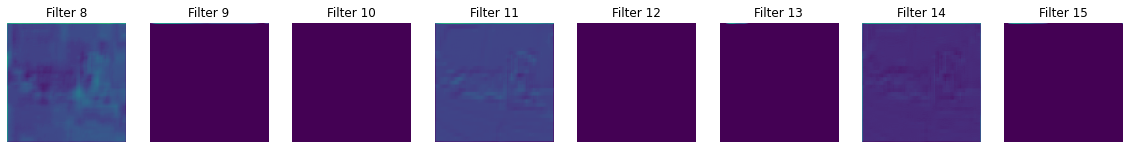

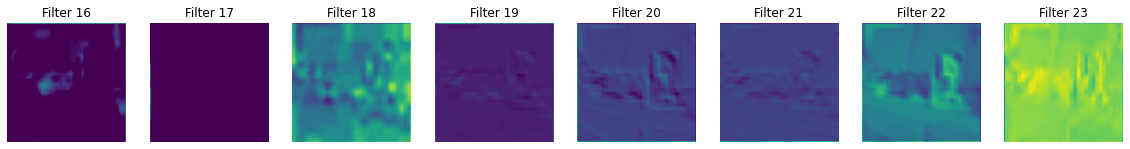

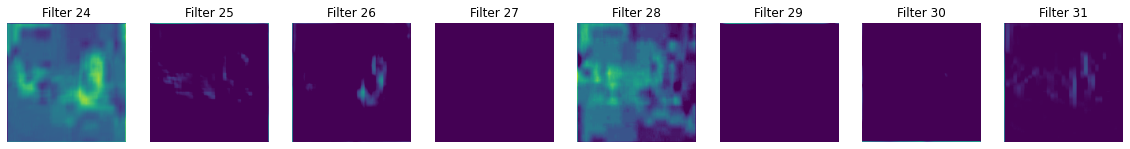

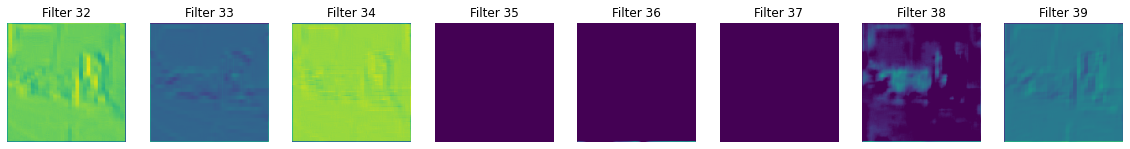

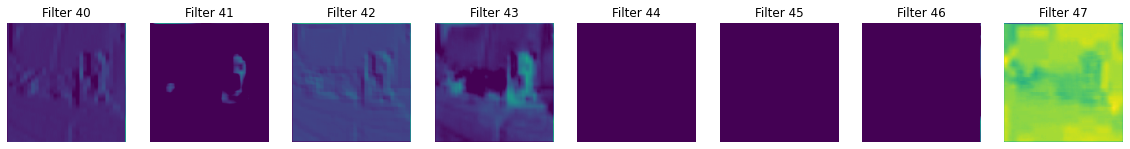

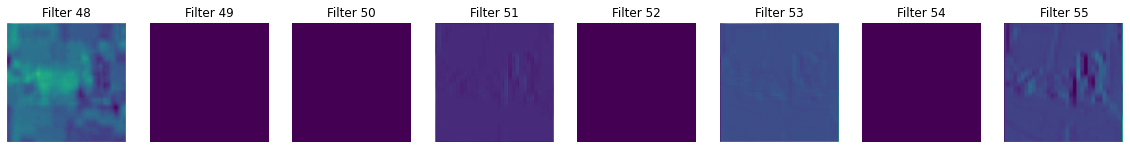

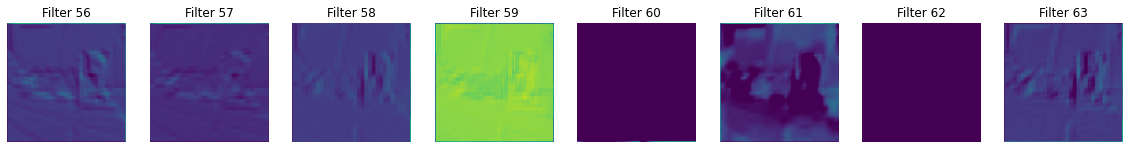

In [4]:
import matplotlib.pyplot as plt

def plot_activations_for_subset_of_filters(layer_activations, num_images=1, filters_per_fig=16):
    # Assuming layer_activations shape is [batch_size, num_filters, height, width]
    _, num_filters, _, _ = layer_activations.shape
    
    # Limit the number of images
    num_images = min(layer_activations.shape[0], num_images)
    
    # Iterate over filters in sets
    for start_filter in range(0, num_filters, filters_per_fig):
        end_filter = min(start_filter + filters_per_fig, num_filters)
        fig, axes = plt.subplots(num_images, end_filter - start_filter, figsize=(20, 10))

        for i in range(num_images):
            for j, filter_idx in enumerate(range(start_filter, end_filter)):
                ax = axes[i, j] if num_images > 1 else axes[j]
                ax.imshow(layer_activations[i, filter_idx].cpu().numpy(), cmap='viridis')
                ax.axis('off')
                ax.set_title(f'Filter {filter_idx}')

        plt.show()

# Example: Plot activations for the first conv layer for 5 images
plot_activations_for_subset_of_filters(activations['features.0'], num_images=1, filters_per_fig=8)


In [5]:
# Example: Collect activations for two classes
class_indices = [3, 5]  # Example class indices

class_activations = {}
for class_index in class_indices:
    class_loader = get_class_loader(trainset, class_index)
    class_images, _ = next(iter(class_loader))
    output = model(class_images)

    class_activations[class_index] = dict(activations)

# Now class_activations contains activations for each class in one batch
# You can compare these, e.g., by computing and comparing statistics


In [6]:
# Function to compute various statistics of activations
def compute_activation_statistics(activation_dict):
    stats = {}
    for layer, activation in activation_dict.items():
        stats[layer] = {
            'mean': activation.mean().item(),
            'std': activation.std().item(),
            'median': activation.median().item(),
            'min': activation.min().item(),
            'max': activation.max().item(),
            'range': activation.max().item() - activation.min().item()
        }
    return stats

# Dictionary to store statistics for each class
class_stats = {}

# Assuming 'class_activations' is a dictionary with class indices as keys
# and activations (from different layers) as values

# Compute statistics for each class
for class_index, activations in class_activations.items():
    class_stats[class_index] = compute_activation_statistics(activations)

# Print all statistical values for each class and layer
for layer in class_stats[class_indices[0]].keys():
    print(f"Layer: {layer}")
    for class_index in class_indices:
        stats = class_stats[class_index][layer]
        print(f"Class {class_index}:")
        print(f"  Mean: {stats['mean']}")
        print(f"  Standard Deviation: {stats['std']}")
        print(f"  Median: {stats['median']}")
        print(f"  Min: {stats['min']}")
        print(f"  Max: {stats['max']}")
        print(f"  Range: {stats['range']}")
        print()


Layer: features.0
Class 3:
  Mean: 0.1823410838842392
  Standard Deviation: 0.20654384791851044
  Median: 0.09068796783685684
  Min: 0.0
  Max: 4.457525253295898
  Range: 4.457525253295898

Class 5:
  Mean: 0.18389403820037842
  Standard Deviation: 0.20952698588371277
  Median: 0.10241871327161789
  Min: 0.0
  Max: 4.908128261566162
  Range: 4.908128261566162

Layer: features.2
Class 3:
  Mean: 0.16341319680213928
  Standard Deviation: 0.3142246901988983
  Median: 0.0
  Min: 0.0
  Max: 6.604915142059326
  Range: 6.604915142059326

Class 5:
  Mean: 0.16865134239196777
  Standard Deviation: 0.3254321217536926
  Median: 0.0
  Min: 0.0
  Max: 7.4862380027771
  Range: 7.4862380027771

Layer: features.5
Class 3:
  Mean: 0.32003527879714966
  Standard Deviation: 0.3760620355606079
  Median: 0.18552514910697937
  Min: 0.0
  Max: 8.037567138671875
  Range: 8.037567138671875

Class 5:
  Mean: 0.3301122188568115
  Standard Deviation: 0.39620596170425415
  Median: 0.18536043167114258
  Min: 0.0
  

In [18]:
pip install xlsxwriter


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 1.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
for layer_name, activation in activations.items():
    print(f"Layer: {layer_name}, Activation Shape: {activation.shape}")
    print(activation)
    
# activation_2d = activation.view(-1, activation.shape[-1] * activation.shape[-2])

# # Convert to a DataFrame
# df = pd.DataFrame(activation_2d.numpy())

# # Now, save the DataFrame to an Excel file
# df.to_excel("activation_data.xlsx", index=False)

import pandas as pd

MAX_COLS = 16384

with pd.ExcelWriter('activations.xlsx', engine='xlsxwriter') as writer:
    for layer_name, activation in activations.items():
        print(f"Layer: {layer_name}, Activation Shape: {activation.shape}")
        
        # Flatten or reshape your tensor
        activation_2d = activation.view(-1, activation.shape[-1] * activation.shape[-2])
        
        # Convert to a DataFrame
        df = pd.DataFrame(activation_2d.numpy())
        
        # Write each chunk of the DataFrame to a different sheet
        for start_col in range(0, df.shape[1], MAX_COLS):
            end_col = min(start_col + MAX_COLS, df.shape[1])
            sheet_name = f'{layer_name}_Sheet{start_col // MAX_COLS + 1}'
            df.iloc[:, start_col:end_col].to_excel(writer, sheet_name=sheet_name, index=False)



Layer: features.0, Activation Shape: torch.Size([4, 64, 224, 224])
tensor([[[[0.7987, 0.4402, 0.4402,  ..., 0.4227, 0.4227, 0.3542],
          [0.9973, 0.4749, 0.4749,  ..., 0.4189, 0.4189, 0.3222],
          [0.9973, 0.4749, 0.4749,  ..., 0.4189, 0.4189, 0.3222],
          ...,
          [0.7000, 0.4238, 0.4238,  ..., 0.4809, 0.4809, 0.0365],
          [0.7000, 0.4238, 0.4238,  ..., 0.4809, 0.4809, 0.0365],
          [0.7399, 0.5265, 0.5265,  ..., 0.5727, 0.5727, 0.2533]],

         [[1.7799, 0.4531, 0.4531,  ..., 0.4857, 0.4857, 0.0000],
          [1.7588, 0.3849, 0.3849,  ..., 0.3832, 0.3832, 0.0000],
          [1.7588, 0.3849, 0.3849,  ..., 0.3832, 0.3832, 0.0000],
          ...,
          [1.7634, 0.3851, 0.3851,  ..., 0.3796, 0.3796, 0.0000],
          [1.7634, 0.3851, 0.3851,  ..., 0.3796, 0.3796, 0.0000],
          [0.5274, 0.0000, 0.0000,  ..., 0.1397, 0.1397, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.5383, 0.4761, 0.4761,  ..., 

Layer: features.0, Activation Shape: torch.Size([4, 64, 224, 224])
Layer: features.2, Activation Shape: torch.Size([4, 64, 224, 224])
Layer: features.5, Activation Shape: torch.Size([4, 128, 112, 112])
Layer: features.7, Activation Shape: torch.Size([4, 128, 112, 112])
Layer: features.10, Activation Shape: torch.Size([4, 256, 56, 56])
Layer: features.12, Activation Shape: torch.Size([4, 256, 56, 56])
Layer: features.14, Activation Shape: torch.Size([4, 256, 56, 56])
Layer: features.17, Activation Shape: torch.Size([4, 512, 28, 28])
Layer: features.19, Activation Shape: torch.Size([4, 512, 28, 28])
Layer: features.21, Activation Shape: torch.Size([4, 512, 28, 28])
Layer: features.24, Activation Shape: torch.Size([4, 512, 14, 14])
Layer: features.26, Activation Shape: torch.Size([4, 512, 14, 14])
Layer: features.28, Activation Shape: torch.Size([4, 512, 14, 14])
Layer: classifier.0, Activation Shape: torch.Size([4, 4096])
Layer: classifier.3, Activation Shape: torch.Size([4, 4096])
Layer

In [5]:
#save average activations per batch instead of individual image activations.
import pandas as pd
# Global dictionary to store average activations
average_activations = {}

def get_average_activation(name):
    def hook(model, input, output):
        # Compute the mean over the batch dimension (dim=0) and detach from the graph
        average_activations[name] = torch.mean(output, dim=0).detach()
    return hook

# Register hooks with the modified get_average_activation function
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Conv2d) or isinstance(layer, torch.nn.Linear):
        layer.register_forward_hook(get_average_activation(name))


# Now, when you run a forward pass on a batch of images:
output = model(class_images)

# At this point, 'average_activations' will contain the average activations for the specific class
# and batch, with the shape of each entry corresponding to the shape of that layer's output
# minus the batch dimension.

MAX_COLS = 16384  # Maximum number of columns per sheet in Excel

with pd.ExcelWriter('activations.xlsx', engine='xlsxwriter') as writer:
    for layer_name, activation in average_activations.items():
        print(f"Layer: {layer_name}, Average Activation Shape: {activation.shape}")
        
        activation_2d = activation.view(activation.shape[0], -1)
        df = pd.DataFrame(activation_2d.numpy())
        
        for start_col in range(0, df.shape[1], MAX_COLS):
            end_col = min(start_col + MAX_COLS, df.shape[1])
            sheet_name = f'{layer_name}_Sheet{start_col // MAX_COLS + 1}'
            df.iloc[:, start_col:end_col].to_excel(writer, sheet_name=sheet_name, index=False)


Layer: features.0, Average Activation Shape: torch.Size([64, 224, 224])
Layer: features.2, Average Activation Shape: torch.Size([64, 224, 224])
Layer: features.5, Average Activation Shape: torch.Size([128, 112, 112])
Layer: features.7, Average Activation Shape: torch.Size([128, 112, 112])
Layer: features.10, Average Activation Shape: torch.Size([256, 56, 56])
Layer: features.12, Average Activation Shape: torch.Size([256, 56, 56])
Layer: features.14, Average Activation Shape: torch.Size([256, 56, 56])
Layer: features.17, Average Activation Shape: torch.Size([512, 28, 28])
Layer: features.19, Average Activation Shape: torch.Size([512, 28, 28])
Layer: features.21, Average Activation Shape: torch.Size([512, 28, 28])
Layer: features.24, Average Activation Shape: torch.Size([512, 14, 14])
Layer: features.26, Average Activation Shape: torch.Size([512, 14, 14])
Layer: features.28, Average Activation Shape: torch.Size([512, 14, 14])
Layer: classifier.0, Average Activation Shape: torch.Size([409

In [ ]:
# # Example: Collect activations for entire dataset for two classes
# class_indices = [3, 5]  # Example class indices

# class_activations = {class_index: [] for class_index in class_indices}

# for class_index in class_indices:
#     class_loader = get_class_loader(trainset, class_index)
    
#     for images, _ in class_loader:
#         output = model(images)
#         class_activations[class_index].append(dict(activations))




In [7]:
lrp_instance.model

VGG(
  (features): Sequential(
    (0): LrpZBoxRule(
      (layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (low_layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (high_layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ReLU(inplace=True)
    (2): LrpGammaRule(
      (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (copy_layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): LrpGammaRule(
      (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (copy_layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (6): ReLU(inplace=True)
    (7): LrpGammaRule(
      (layer): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (copy_layer): Conv

In [4]:
for layers, rule, params in name_map:
    for layer in layers:
        print(f'{layer} {rule.__name__}')

features.0 LrpZBoxRule
features.2 LrpGammaRule
features.5 LrpGammaRule
features.7 LrpGammaRule
features.10 LrpGammaRule
features.12 LrpGammaRule
features.14 LrpGammaRule
features.17 LrpEpsilonRule
features.19 LrpEpsilonRule
features.21 LrpEpsilonRule
features.24 LrpEpsilonRule
features.26 LrpEpsilonRule
features.28 LrpEpsilonRule
avgpool LrpZeroRule
classifier.0 LrpZeroRule
classifier.3 LrpZeroRule
classifier.6 LrpZeroRule
